In [125]:
# Import

import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import json
import re
import networkx as nx

In [126]:
def load_jsonc(filepath):
    """Load JSONC file (JSON with comments)"""
    with open(filepath, 'r', encoding='utf-8') as f:
        content = f.read()
    
    # Remove single-line comments (// ...)
    content = re.sub(r'//.*?$', '', content, flags=re.MULTILINE)
    
    # Remove multi-line comments (/* ... */)
    content = re.sub(r'/\*.*?\*/', '', content, flags=re.DOTALL)
    
    # Remove trailing commas before closing brackets/braces
    content = re.sub(r',\s*([}\]])', r'\1', content)
    
    return json.loads(content)

def load_json(filepath):
    """Load regular JSON file"""
    with open(filepath, 'r', encoding='utf-8') as f:
        return json.load(f)

def load_any(filepath):
    """Load either JSON or JSONC file based on extension"""
    if filepath.endswith('.jsonc'):
        return load_jsonc(filepath)
    else:
        return load_json(filepath)

In [127]:
# TASK 1: relocate age_weights to parameters.jsonc file
input_dir = './input_data'
stage_dirs = ['amd_sim_data', 'amd_sim_data_Early', 'amd_sim_data_Intermediate', 'amd_sim_data_Late-dry', 'amd_sim_data_Late-wet']

for stage_dir in stage_dirs:
    parameters = load_jsonc(f'{input_dir}/{stage_dir}/parameters.jsonc')
    print(f'{stage_dir:<30} parameters keys: {parameters.keys()}')

amd_sim_data                   parameters keys: dict_keys(['rr', 'f', 'i', 'age_weights', 'ages', 'p', 'r', 'pf', 'X'])
amd_sim_data_Early             parameters keys: dict_keys(['rr', 'f', 'i', 'age_weights', 'ages', 'p', 'r', 'pf', 'X'])
amd_sim_data_Intermediate      parameters keys: dict_keys(['rr', 'f', 'i', 'age_weights', 'ages', 'p', 'r', 'pf', 'X'])
amd_sim_data_Late-dry          parameters keys: dict_keys(['rr', 'f', 'i', 'age_weights', 'ages', 'p', 'r', 'pf', 'X'])
amd_sim_data_Late-wet          parameters keys: dict_keys(['rr', 'f', 'i', 'age_weights', 'ages', 'p', 'r', 'pf', 'X'])


In [128]:
# TASK 2: update Load based on region_id_graph
stage_dirs = ['amd_sim_data', 'amd_sim_data_Early', 'amd_sim_data_Intermediate', 'amd_sim_data_Late-dry', 'amd_sim_data_Late-wet']
stage = stage_dirs[2] # Intermediate

#------------------------------------------------------------------------------------------------------------#
# Read input data

input_data = pd.read_csv(f'{input_dir}/{stage}/input_data.csv')
output_template = pd.read_csv(f'{input_dir}/{stage}/output_template.csv')
parameters = load_any(f'{input_dir}/{stage}/parameters.jsonc')    # dict. {'p': {}, 'age_weights': [], 'ages: []}
hierarchy = load_any(f'{input_dir}/{stage}/hierarchy.json')       # dict of lists. {'nodes': [], 'edges': []}
nodes_to_fit = load_any(f'{input_dir}/{stage}/nodes_to_fit.json') # LIST of strings

print(f'number of rows: {len(input_data)}')
print(f'number of unique location_id: {input_data["location_id"].nunique()}')
print('--------------------------------')

#------------------------------------------------------------------------------------------------------------#
# Create region_graph
nodes = hierarchy['nodes']
name_to_id = {} # warning: this does not handle duplicate names
id_to_name = {}

region_id_graph = nx.DiGraph()

for node in nodes:
  name_to_id[node[0]] = node[1]['location_id']
  id_to_name[node[1]['location_id']] = node[0]

  # create region_id_graph
  region_id_graph.add_node(node[1]['location_id'],
                            level = node[1]['level'],
                            parent_id = node[1]['parent_id'],
                            name = node[0]
                          )

  my_id = node[1]['location_id']
  parent_id = node[1]['parent_id']
  if my_id != parent_id: # if my_id is not the root node
    region_id_graph.add_edge(parent_id, my_id)

print(f"number of nodes: {region_id_graph.number_of_nodes()}") 
print(f"number of edges: {region_id_graph.number_of_edges()}")

number of rows: 207
number of unique location_id: 18
--------------------------------
number of nodes: 233
number of edges: 232


In [129]:
print(id_to_name[422]) # IDs are not incremental

print(region_id_graph.nodes[422]['level'])
print(region_id_graph.nodes[422]['parent_id'])
print(region_id_graph.nodes[422]['name'])

United States Virgin Islands
3
104
United States Virgin Islands


In [130]:
# TASK 3: define "coords"

country_list = []
region_list = []
super_region_list = []

for node in hierarchy['nodes']:
  if node[1]['level'] == 3:
    country_list.append(node[1]['location_id'])
  elif node[1]['level'] == 2:
    region_list.append(node[1]['location_id'])
  elif node[1]['level'] == 1:
    super_region_list.append(node[1]['location_id'])
    
coords = {
    "country":      country_list,
    "region":       region_list,
    "super_region": super_region_list,
}

print(len(country_list))
print(len(region_list))
print(len(super_region_list))

204
21
7


In [131]:
# Utilizes id_to_name to print the name of the location
def describe():
        G = region_id_graph
        df = input_data
        for n in nx.dfs_postorder_nodes(G, 1):
            cnt = df['location_id'].eq(n).sum() + sum(G.nodes[c].get('cnt', 0) for c in G.successors(n))
            G.nodes[n]['cnt'] = int(cnt)
            G.nodes[n]['depth'] = nx.shortest_path_length(G, 1, n)
            
        for n in nx.dfs_preorder_nodes(G, 1):
            if G.nodes[n]['cnt'] > 0:
                print('  '*G.nodes[n]['depth'] + id_to_name[n], G.nodes[n]['cnt'])

# describe()

def keep():
    pass
    # Suggestion: filter input_data during "LOAD"

def filter_input_data_by_data_type(input_data: pd.DataFrame, data_type: str) -> pd.DataFrame:
        if not input_data.empty:
            return input_data[input_data['data_type'] == data_type]
        return input_data

# since our input_data only has 'p' data, this will return the same input_data
filter_input_data_by_data_type(input_data, 'p').head() 

,area,location_id,stage,stage_id,sex,sex_id,year_id,age_start,age_end,effective_sample_size,value,standard_error,x_sdi,x_tob,data_type,upper_ci,lower_ci,age_weights
0,Netherlands,89,Intermediate,5,Male,1,1990,55,64,1418.0,0.040903,0.005260,0.794612,0.434156,p,NaN,NaN,NaN
1,Netherlands,89,Intermediate,5,Female,2,1990,55,64,1802.0,0.033851,0.004260,0.794612,0.383810,p,NaN,NaN,NaN
2,Netherlands,89,Intermediate,5,Male,1,1990,65,74,1382.0,0.072359,0.006969,0.794612,0.434156,p,NaN,NaN,NaN
3,Netherlands,89,Intermediate,5,Female,2,1990,65,74,1865.0,0.036997,0.004371,0.794612,0.383810,p,NaN,NaN,NaN
4,Netherlands,89,Intermediate,5,Male,1,1990,75,84,796.0,0.103015,0.010774,0.794612,0.434156,p,NaN,NaN,NaN


In [132]:
describe()

Global 207
  Central Europe, Eastern Europe, and Central Asia 6
    Eastern Europe 6
      Russian Federation 6
  High-income 146
    Australasia 13
      Australia 13
    High-income Asia Pacific 32
      Japan 19
      Republic of Korea 2
      Singapore 11
    High-income North America 55
      United States of America 55
    Western Europe 46
      Germany 3
      Iceland 5
      Ireland 10
      Italy 14
      Netherlands 8
      Spain 6
  North Africa and Middle East 2
    North Africa and Middle East 2
      Iran (Islamic Republic of) 2
  South Asia 15
    South Asia 15
      India 10
      Nepal 5
  Southeast Asia, East Asia, and Oceania 38
    East Asia 34
      China 24
      Taiwan (Province of China) 10
    Southeast Asia 4
      Thailand 4


In [133]:
# process.asr() | parameters
# ------------------------------------------------------------
data_type                = 'p'
reference_area           = 'Global'
reference_sex            = 'Both'
reference_year           = 'all'
mu_age                   = None
mu_age_parent            = None
sigma_age_parent         = None
rate_type                = 'neg_binom'
lower_bound              = None
interpolation_method     = 'linear'
include_covariates       = False
zero_re                  = False
# ------------------------------------------------------------

In [134]:
name_to_id['Global']

1

In [135]:
# process.asr() | local variables
# ------------------------------------------------------------
ages = np.array(parameters['ages'], dtype=np.float64)
age_weights = np.array(parameters['age_weights'], dtype=np.float64)
data = filter_input_data_by_data_type(input_data, data_type)
lb_data = filter_input_data_by_data_type(input_data, lower_bound) if lower_bound else None
params_of_data_type = parameters.get(data_type, {})

# check: mu_age_parent & sigma_age_parent
#  if either mu_age_parent or sigma_age_parent is NaN, set them to None
if (isinstance(mu_age_parent, np.ndarray) and np.isnan(mu_age_parent).any()) or \
    (isinstance(sigma_age_parent, np.ndarray) and np.isnan(sigma_age_parent).any()):

    mu_age_parent = None
    sigma_age_parent = None
# ------------------------------------------------------------
print(f'ages: {ages} | type: {type(ages)} | ages.dtype: {ages.dtype}')

ages: [ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19.
 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37.
 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54. 55.
 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72. 73.
 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. 89. 90. 91.
 92. 93. 94.] | type: <class 'numpy.ndarray'> | ages.dtype: float64


In [136]:
# process.asr() | [1] Prepare spline.spline (knots, smoothing)
# ------------------------------------------------------------
knots = np.array(params_of_data_type.get('parameter_age_mesh', np.arange(ages[0], ages[-1] + 1, 5)), dtype=np.float64)
# knots = np.ndarry: array([ 2, 30, 45, 60, 80, 94])

smooth_map = {'No Prior': np.inf, 'Slightly': 0.5, 'Moderately': 0.05, 'Very': 0.005}  # type(np.inf) == float
smoothness_param = params_of_data_type.get('smoothness')

if isinstance(smoothness_param, dict): 
    amount = smoothness_param.get('amount')

    if isinstance(amount, (int, float)): # smoothness_param is dict, and amount is int or float
        smoothing = float(amount)
    else:                                # smoothness_param is dict, and amount may be string
        smoothing = smooth_map.get(amount, 0.0)

else:                                    # smoothness_param may be string
    smoothing = smooth_map.get(smoothness_param, 0.0)
# after all, smoothing is float

# ------------------------------------------------------------
print(f'knots: {knots} | type: {type(knots)} | knots.dtype: {knots.dtype}')
print(f'smoothing: {smoothing}')

knots: [ 2. 30. 45. 60. 80. 94.] | type: <class 'numpy.ndarray'> | knots.dtype: float64
smoothing: 0.5


In [137]:
def inspect_model(model, var_name=None, show_shared_data=True):
    """
    Inspect a PyMC model. If var_name is None, print a summary,
    plus any shared_data contents. Otherwise, show details about a specific variable.
    """
    if var_name is None:
        print("📊 Model Summary:")
        print(f"  • Free RVs       : {len(model.free_RVs)} {[rv.name for rv in model.free_RVs]}")
        print(f"  • Observed RVs   : {len(model.observed_RVs)} {[rv.name for rv in model.observed_RVs]}")
        print(f"  • Deterministics : {len(model.deterministics)} {[rv.name for rv in model.deterministics]}")
        print(f"  • Potentials     : {len(model.potentials)} {[pot.name for pot in model.potentials]}")
        print(f"  • Total Named RVs: {len(model.named_vars)}")

        # --- Print shared_data contents if present ---
        if show_shared_data:
            if hasattr(model, "shared_data"):
                sd = model.shared_data
                if isinstance(sd, dict) and sd:
                    print("\n🔖 shared_data:")
                    for key, val in sd.items():
                        if isinstance(val, np.ndarray):
                            print(f"  • {key:15s}: array, shape={val.shape}, dtype={val.dtype}")
                        else:
                            print(f"  • {key:15s}: {val!r}")

    else:
        var_dict = model.named_vars
        if var_name not in var_dict:
            print(f"❌ Variable '{var_name}' not found in model.named_vars.")
            return

        var = var_dict[var_name]
        print(f"🔍 Variable: {var_name}")
        print(f"  • Type     : {type(var)}")
        print(f"  • Shape    : {getattr(var, 'shape', None)}")
        print(f"  • DType    : {getattr(var, 'dtype', None)}")
        print(f"  • Owner OP : {var.owner.op if getattr(var, 'owner', None) else 'None'}")

        if hasattr(var, 'distribution'):
            dist = var.distribution
            print(f"  • Distribution: {dist.__class__.__name__}")
            if hasattr(dist, 'dist'):
                print(f"    - PyMC Dist : {dist.dist.__class__.__name__}")
            if hasattr(dist, 'kwargs'):
                print("    - Parameters:")
                for k, v in dist.kwargs.items():
                    print(f"      {k}: {v}")

        if hasattr(var, 'eval'):
            try:
                val = var.eval()
                print(f"  • Current value (eval): {val}")
            except Exception as e:
                print(f"  • Could not evaluate variable: {e}")


In [138]:
pm_model = pm.Model()

with pm_model: 
    pm_model.shared_data = {    # NOTE: this is what used to be "vars" from class ModelVars
        "data_type": data_type,
        "ages":      ages,
        "age_weights": age_weights,
        "data":      data,
        "lb_data":   lb_data,
        "knots":     knots,
        "smoothing": smoothing,
        "interpolation_method": interpolation_method,
        "params_of_data_type": params_of_data_type,
        "reference_area_id": name_to_id[reference_area],
        "reference_sex": reference_sex,
        "reference_year": reference_year,
        "zero_re": zero_re,
        "region_id_graph": region_id_graph,
        "output_template": output_template,
    }

inspect_model(pm_model)

📊 Model Summary:
  • Free RVs       : 0 []
  • Observed RVs   : 0 []
  • Deterministics : 0 []
  • Potentials     : 0 []
  • Total Named RVs: 0

🔖 shared_data:
  • data_type      : 'p'
  • ages           : array, shape=(93,), dtype=float64
  • age_weights    : array, shape=(101,), dtype=float64
  • data           :                          area  location_id         stage  stage_id     sex   
0                 Netherlands           89  Intermediate         5    Male  \
1                 Netherlands           89  Intermediate         5  Female   
2                 Netherlands           89  Intermediate         5    Male   
3                 Netherlands           89  Intermediate         5  Female   
4                 Netherlands           89  Intermediate         5    Male   
..                        ...          ...           ...       ...     ...   
202                   Ireland           84  Intermediate         5    Both   
203                   Germany           81  Intermediate   

In [139]:
# process.asr() | (1) spline.py
import model.spline as spline
print(spline.__file__)

with pm_model:
    if mu_age is not None:
        unconstrained_mu_age = mu_age
        
    else:
        unconstrained_mu_age = spline.spline()
        
# unconstrained_mu_age is a PyTensor variable deterministic by gamma_p

/Users/Dev/AMD/dismod_mr_migrated/reforged_mr/model/spline.py


In [140]:
inspect_model(pm_model, show_shared_data=False)

📊 Model Summary:
  • Free RVs       : 1 ['gamma_p']
  • Observed RVs   : 0 []
  • Deterministics : 1 ['mu_age_p']
  • Potentials     : 1 ['smooth_p']
  • Total Named RVs: 3


In [141]:
inspect_model(pm_model, var_name='gamma_p', show_shared_data=False)

🔍 Variable: gamma_p
  • Type     : <class 'pytensor.tensor.var.TensorVariable'>
  • Shape    : TensorConstant{(1,) of 6}
  • DType    : float64
  • Owner OP : normal_rv{0, (0, 0), floatX, False}
  • Current value (eval): [ -6.91370291 -27.05946605   1.40645021   2.04183078  13.07447787
  -3.56160099]


In [142]:
inspect_model(pm_model, var_name='mu_age_p', show_shared_data=False)

🔍 Variable: mu_age_p
  • Type     : <class 'pytensor.tensor.var.TensorVariable'>
  • Shape    : TensorConstant{(1,) of 93}
  • DType    : float64
  • Owner OP : Elemwise{identity}
  • Current value (eval): [9.94070025e-04 9.58567525e-04 9.23065024e-04 8.87562523e-04
 8.52060022e-04 8.16557521e-04 7.81055020e-04 7.45552519e-04
 7.10050019e-04 6.74547518e-04 6.39045017e-04 6.03542516e-04
 5.68040015e-04 5.32537514e-04 4.97035014e-04 4.61532513e-04
 4.26030012e-04 3.90527511e-04 3.55025010e-04 3.19522509e-04
 2.84020009e-04 2.48517508e-04 2.13015007e-04 1.77512506e-04
 1.42010005e-04 1.06507504e-04 7.10050035e-05 3.55025026e-05
 1.77101896e-12 2.72096093e-01 5.44192187e-01 8.16288280e-01
 1.08838437e+00 1.36048047e+00 1.63257656e+00 1.90467265e+00
 2.17676875e+00 2.44886484e+00 2.72096093e+00 2.99305703e+00
 3.26515312e+00 3.53724921e+00 3.80934531e+00 4.08144140e+00
 4.32299210e+00 4.56454280e+00 4.80609351e+00 5.04764421e+00
 5.28919491e+00 5.53074562e+00 5.77229632e+00 6.01384702e+00
 

In [143]:
# process.asr() | (2) priors.py - level_constraints()
import model.priors as priors
print(priors.__file__)

with pm_model:
    constrained_mu_age = priors.level_constraints(unconstrained_mu_age)

/Users/Dev/AMD/dismod_mr_migrated/reforged_mr/model/priors.py


In [144]:
unconstrained_mu_age.name

'mu_age_p'

In [145]:
constrained_mu_age.name

'constrained_mu_age_p'

In [146]:
inspect_model(pm_model, show_shared_data=False)

📊 Model Summary:
  • Free RVs       : 1 ['gamma_p']
  • Observed RVs   : 0 []
  • Deterministics : 2 ['mu_age_p', 'constrained_mu_age_p']
  • Potentials     : 2 ['smooth_p', 'parent_similarity_p_level_constraints']
  • Total Named RVs: 5


In [147]:
# process.asr() | (3) priors.py - derivative_constraints()
with pm_model:    
    priors.derivative_constraints(mu_age=constrained_mu_age)

In [148]:
inspect_model(pm_model, show_shared_data=False)

📊 Model Summary:
  • Free RVs       : 1 ['gamma_p']
  • Observed RVs   : 0 []
  • Deterministics : 2 ['mu_age_p', 'constrained_mu_age_p']
  • Potentials     : 3 ['smooth_p', 'parent_similarity_p_level_constraints', 'mu_age_derivative_potential_p']
  • Total Named RVs: 6


In [149]:
# process.asr() | (4) priors.py - similar()
with pm_model:    
    if mu_age_parent is not None:
        priors.similar(
            mu_child=constrained_mu_age,
            mu_parent=mu_age_parent,
            sigma_parent=sigma_age_parent,
            sigma_difference=0.0,
            eps=1e-9,
            penalty_name="_mu_age_parent_not_none"
        )

In [150]:
inspect_model(pm_model, show_shared_data=False)

📊 Model Summary:
  • Free RVs       : 1 ['gamma_p']
  • Observed RVs   : 0 []
  • Deterministics : 2 ['mu_age_p', 'constrained_mu_age_p']
  • Potentials     : 3 ['smooth_p', 'parent_similarity_p_level_constraints', 'mu_age_derivative_potential_p']
  • Total Named RVs: 6


In [151]:
# process.asr() | (5) age_groups.py - age_standardize_approx()
#               | (6) covariate.py - mean_covariate_model()
import model.age_groups as age_groups
import model.covariates as covariates
print(age_groups.__file__)
print(covariates.__file__)

with pm_model:    
    if len(data) > 0:
        mu_interval = age_groups.age_standardize_approx(mu_age=constrained_mu_age)

        # 2-2) covariate & pi
        if include_covariates:
            pi, U, U_shift, sigma_alpha, alpha, alpha_potentials, const_alpha_sigma, X, X_shift, beta, const_beta_sigma = covariates.mean_covariate_model(mu=mu_interval)

        else:
            pi = mu_interval

/Users/Dev/AMD/dismod_mr_migrated/reforged_mr/model/age_groups.py
/Users/Dev/AMD/dismod_mr_migrated/reforged_mr/model/covariates.py


In [152]:
inspect_model(pm_model, show_shared_data=False)

📊 Model Summary:
  • Free RVs       : 1 ['gamma_p']
  • Observed RVs   : 0 []
  • Deterministics : 4 ['mu_age_p', 'constrained_mu_age_p', 'cum_sum_mu_p', 'mu_interval_p']
  • Potentials     : 3 ['smooth_p', 'parent_similarity_p_level_constraints', 'mu_age_derivative_potential_p']
  • Total Named RVs: 8


In [153]:
inspect_model(pm_model, 'pi_p')

❌ Variable 'pi_p' not found in model.named_vars.


In [154]:
# process.asr() | (7) covariate.py - mean_covariate_model()

with pm_model:    
    if len(data) <= 0:
        if include_covariates:
            pi, U, U_shift, sigma_alpha, alpha, alpha_potentials, const_alpha_sigma, X, X_shift, beta, const_beta_sigma = covariates.mean_covariate_model(mu=None)


inspect_model(pm_model, show_shared_data=False)

📊 Model Summary:
  • Free RVs       : 1 ['gamma_p']
  • Observed RVs   : 0 []
  • Deterministics : 4 ['mu_age_p', 'constrained_mu_age_p', 'cum_sum_mu_p', 'mu_interval_p']
  • Potentials     : 3 ['smooth_p', 'parent_similarity_p_level_constraints', 'mu_age_derivative_potential_p']
  • Total Named RVs: 8


In [155]:
rate_types = ['beta_binom', 'binom', 'neg_binom', 'poisson', 'log_normal', 'normal', 'offset_log_normal']
rate_type = rate_types[2]

In [156]:
with pm_model:
    if len(data) > 0:
        data = data.copy()
        # 1) Identify rows where SE is “invalid” (< 0) and recompute them
        invalid_se_mask = data['standard_error'] < 0
        se_replacement = (data['upper_ci'] - data['lower_ci']) / (2 * 1.96)
        se = data['standard_error'].mask(invalid_se_mask, se_replacement)
        num_se_augmented = int(invalid_se_mask.sum())

        # 2) Identify rows where ESS is missing and compute from p(1–p)/SE²
        missing_ess_mask = data['effective_sample_size'].isna()
        ess_replacement = data['value'] * (1 - data['value']) / se**2
        ess = data['effective_sample_size'].fillna(ess_replacement)
        num_ess_augmented = int(missing_ess_mask.sum())

        # 3) Write back and report
        data['standard_error'] = se
        data['effective_sample_size'] = ess

        print(f"Standard errors replaced: {num_se_augmented}")
        print(f"Effective sample sizes filled: {num_ess_augmented}")


        # Binom
        # bad_ess = data['effective_sample_size'] < 0
        # if bad_ess.any():
        #     data.loc[bad_ess, 'effective_sample_size'] = 0.0

        # likelihood.binom(pi=pi)


        # # neg_binom
        # bad_ess = (data['effective_sample_size'] <= 0) | data['effective_sample_size'].isna()
        # if bad_ess.any():
        #     data.loc[bad_ess, 'effective_sample_size'] = 0.0

        # big_ess = data['effective_sample_size'] >= 1e10
        # if big_ess.any():
        #     data.loc[big_ess, 'effective_sample_size'] = 1e10

        # hetero = parameters.get('heterogeneity', None)
        # lower = {'Slightly': 9.0, 'Moderately': 3.0, 'Very': 1.0}.get(hetero, 1.0)
        # if data_type == 'pf':
        #     lower = 1e12

        # delta = covariates.dispersion_covariate_model(delta_lb=lower, delta_ub=lower * 9.0)
        
        # likelihood.neg_binom(pi=pi, delta=delta)  

        
        # Beta-binom
        # bad_ess = (data['effective_sample_size'] <= 0) | data['effective_sample_size'].isna()
        # if bad_ess.any():
        #     data.loc[bad_ess, 'effective_sample_size'] = 0.0

        # big_ess = data['effective_sample_size'] >= 1e10
        # if big_ess.any():
        #     data.loc[big_ess, 'effective_sample_size'] = 1e10

        # hetero = parameters.get('heterogeneity', None)
        # lower = {'Slightly': 9.0, 'Moderately': 3.0, 'Very': 1.0}.get(hetero, 1.0)
        # if data_type == 'pf':
        #     lower = 1e12

        # delta = covariates.dispersion_covariate_model(delta_lb=lower, delta_ub=lower * 9.0)

        # likelihood.beta_binom(pi=pi, delta=delta)


        # # log-normal
        # missing = data['standard_error'] < 0
        # if missing.any():
        #     data.loc[missing, 'standard_error'] = 1e6

        # sigma = pm.Uniform(
        #     name=f'sigma_{data_type}',
        #     lower=1e-4,
        #     upper=1.0,
        #     initval=1e-2,
        # )

        # likelihood.log_normal(pi=pi, sigma=sigma)


        # normal
        # missing = data['standard_error'] < 0
        # if missing.any():
        #     data.loc[missing, 'standard_error'] = 1e6

        # sigma_tv = pm.Uniform(
        #     name=f'sigma_{data_type}',
        #     lower=1e-4,
        #     upper=1e-1,
        #     initval=1e-2 
        # )

        # likelihood.normal(pi=pi, sigma=sigma)


        # offset_log_normal
        
        # sigma_tv = pm.Uniform(
        #     name=f'sigma_{data_type}',
        #     lower=1e-4,
        #     upper=10.0,
        #     initval=1e-2
        # )

        # likelihood.offset_log_normal(pi=pi, sigma=sigma_tv)


        # poisson

        # bad_ess = data['effective_sample_size'] < 0
        # if bad_ess.any():
        #     data.loc[bad_ess, 'effective_sample_size'] = 0.0

        # likelihood.poisson(pi=pi)
        

Standard errors replaced: 0
Effective sample sizes filled: 0


In [157]:
# process.asr() | (8) covariate.py - dispersion_covariate_model()
# process.asr() | (9) likelihood.py - neg_binom()
import model.likelihood as likelihood
print(likelihood.__file__)

with pm_model:
    if len(data) > 0:
        if rate_type == 'neg_binom':
            bad_ess = (data['effective_sample_size'] <= 0) | data['effective_sample_size'].isna()
            if bad_ess.any():
                data.loc[bad_ess, 'effective_sample_size'] = 0.0

            big_ess = data['effective_sample_size'] >= 1e10
            if big_ess.any():
                data.loc[big_ess, 'effective_sample_size'] = 1e10

            hetero = parameters.get('heterogeneity', None)
            lower = {'Slightly': 9.0, 'Moderately': 3.0, 'Very': 1.0}.get(hetero, 1.0)
            if data_type == 'pf':
                lower = 1e12

            delta = covariates.dispersion_covariate_model(delta_lb=lower, delta_ub=lower * 9.0)

            likelihood.neg_binom(pi=pi, delta=delta)            


inspect_model(pm_model, show_shared_data=False)

/Users/Dev/AMD/dismod_mr_migrated/reforged_mr/model/likelihood.py
Z: Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[207 rows x 0 columns]
📊 Model Summary:
  • Free RVs       : 2 ['gamma_p', 'eta_p']
  • Observed RVs   : 0 []
  • Deterministics : 6 ['mu_age_p', 'constrained_mu_age_p', 'cum_sum_mu_p', 'mu_interval_p', 'delta_p', 'p_pred_p']
  • Potentials     : 4 ['smooth_p', 'parent_similarity_p_level_constraints', 'mu_age_derivative_potential_p', 'p_obs_p']
  • Total Named RVs: 12


In [158]:
# process.asr() | (10) likelihood.py - log_normal()

with pm_model:
    if len(data) > 0:
        if rate_type == 'log_normal':
            missing = data['standard_error'] < 0
            if missing.any():
                data.loc[missing, 'standard_error'] = 1e6

            sigma = pm.Uniform(
                name=f'sigma_{data_type}',
                lower=1e-4,
                upper=1.0,
                initval=1e-2
            )

            likelihood.log_normal(pi=pi, sigma=sigma)


inspect_model(pm_model, show_shared_data=False)

📊 Model Summary:
  • Free RVs       : 2 ['gamma_p', 'eta_p']
  • Observed RVs   : 0 []
  • Deterministics : 6 ['mu_age_p', 'constrained_mu_age_p', 'cum_sum_mu_p', 'mu_interval_p', 'delta_p', 'p_pred_p']
  • Potentials     : 4 ['smooth_p', 'parent_similarity_p_level_constraints', 'mu_age_derivative_potential_p', 'p_obs_p']
  • Total Named RVs: 12


In [159]:
# process.asr() | (11) likelihood.py - log_normal()

with pm_model:
    if len(data) > 0:
        if rate_type == 'normal':
            missing = data['standard_error'] < 0
            if missing.any():
                data.loc[missing, 'standard_error'] = 1e6

            sigma = pm.Uniform(
                name=f'sigma_{data_type}',
                lower=1e-4,
                upper=1e-1,
                initval=1e-2
            )

            likelihood.normal(pi=pi, sigma=sigma)


inspect_model(pm_model, show_shared_data=False)

📊 Model Summary:
  • Free RVs       : 2 ['gamma_p', 'eta_p']
  • Observed RVs   : 0 []
  • Deterministics : 6 ['mu_age_p', 'constrained_mu_age_p', 'cum_sum_mu_p', 'mu_interval_p', 'delta_p', 'p_pred_p']
  • Potentials     : 4 ['smooth_p', 'parent_similarity_p_level_constraints', 'mu_age_derivative_potential_p', 'p_obs_p']
  • Total Named RVs: 12


In [160]:
# process.asr() | (12) likelihood.py - binom()

with pm_model:
    if len(data) > 0:
        if rate_type == 'binom':
            bad_ess = data['effective_sample_size'] < 0
            if bad_ess.any():
                data.loc[bad_ess, 'effective_sample_size'] = 0.0

            likelihood.binom(pi=pi)


inspect_model(pm_model, show_shared_data=False)

📊 Model Summary:
  • Free RVs       : 2 ['gamma_p', 'eta_p']
  • Observed RVs   : 0 []
  • Deterministics : 6 ['mu_age_p', 'constrained_mu_age_p', 'cum_sum_mu_p', 'mu_interval_p', 'delta_p', 'p_pred_p']
  • Potentials     : 4 ['smooth_p', 'parent_similarity_p_level_constraints', 'mu_age_derivative_potential_p', 'p_obs_p']
  • Total Named RVs: 12


In [161]:
# process.asr() | (13) likelihood.py - beta_binom()

with pm_model:
    if len(data) > 0:
        if rate_type == 'beta_binom':

            ### NEWLY ADDED: Origianl code doesn't have delta_tv calculation
            bad_ess = (data['effective_sample_size'] <= 0) | data['effective_sample_size'].isna()
            if bad_ess.any():
                data.loc[bad_ess, 'effective_sample_size'] = 0.0

            big_ess = data['effective_sample_size'] >= 1e10
            if big_ess.any():
                data.loc[big_ess, 'effective_sample_size'] = 1e10

            hetero = parameters.get('heterogeneity', None)
            lower = {'Slightly': 9.0, 'Moderately': 3.0, 'Very': 1.0}.get(hetero, 1.0)
            if data_type == 'pf':
                lower = 1e12

            delta = covariates.dispersion_covariate_model(delta_lb=lower, delta_ub=lower * 9.0)

            likelihood.beta_binom(pi=pi, delta=delta)


inspect_model(pm_model, show_shared_data=False)

📊 Model Summary:
  • Free RVs       : 2 ['gamma_p', 'eta_p']
  • Observed RVs   : 0 []
  • Deterministics : 6 ['mu_age_p', 'constrained_mu_age_p', 'cum_sum_mu_p', 'mu_interval_p', 'delta_p', 'p_pred_p']
  • Potentials     : 4 ['smooth_p', 'parent_similarity_p_level_constraints', 'mu_age_derivative_potential_p', 'p_obs_p']
  • Total Named RVs: 12


---------------------------------------------------------------------------
IndexError                                Traceback (most recent call last)
Cell In[25], line 23
     19                 lower = 1e12
     21             delta_tv = covariates.dispersion_covariate_model(delta_lb=lower, delta_ub=lower * 9.0)
---> 23             likelihood.beta_binom(pi=pi_tv, delta=delta_tv)
     26 inspect_model(pm_model, show_shared_data=False)

File /Users/Dev/AMD/dismod_mr_migrated/reforged_mr/model/likelihood.py:275, in beta_binom(pi, delta)
    267 alpha_param = pi * delta * 50
    268 beta_param = (1 - pi) * delta * 50
    270 p_obs = pm.BetaBinomial(
    271     name=f'p_obs_{data_type}',
    272     n=n_int[mask],
    273     alpha=alpha_param[mask] if hasattr(alpha_param, 'shape') else alpha_param,
    274     beta=beta_param[mask] if hasattr(beta_param, 'shape') else beta_param,
--> 275     observed=obs_counts[mask]
    276 )
    278 # Posterior predictive counts: replace zero-sample cases
    279 n_pred = n_int.copy()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 207

In [162]:
# process.asr() | (14) likelihood.py - poisson()

with pm_model:
    if len(data) > 0:
        if rate_type == 'poisson':
            bad_ess = data['effective_sample_size'] < 0
            if bad_ess.any():
                data.loc[bad_ess, 'effective_sample_size'] = 0.0

            likelihood.poisson(pi=pi)


inspect_model(pm_model, show_shared_data=False)

📊 Model Summary:
  • Free RVs       : 2 ['gamma_p', 'eta_p']
  • Observed RVs   : 0 []
  • Deterministics : 6 ['mu_age_p', 'constrained_mu_age_p', 'cum_sum_mu_p', 'mu_interval_p', 'delta_p', 'p_pred_p']
  • Potentials     : 4 ['smooth_p', 'parent_similarity_p_level_constraints', 'mu_age_derivative_potential_p', 'p_obs_p']
  • Total Named RVs: 12


In [163]:
# process.asr() | (15) likelihood.py - offset_log_normal()
#               | (16) else

with pm_model:
    if len(data) > 0:
        if rate_type == 'offset_log_normal':
            
            sigma_tv = pm.Uniform(
                name=f'sigma_{data_type}',
                lower=1e-4,
                upper=10.0,
                initval=1e-2
            )

            likelihood.offset_log_normal(pi=pi, sigma=sigma_tv)

        # else:
        #     raise ValueError(f'Unsupported rate_type "{rate_type}"')


inspect_model(pm_model, show_shared_data=False)

📊 Model Summary:
  • Free RVs       : 2 ['gamma_p', 'eta_p']
  • Observed RVs   : 0 []
  • Deterministics : 6 ['mu_age_p', 'constrained_mu_age_p', 'cum_sum_mu_p', 'mu_interval_p', 'delta_p', 'p_pred_p']
  • Potentials     : 4 ['smooth_p', 'parent_similarity_p_level_constraints', 'mu_age_derivative_potential_p', 'p_obs_p']
  • Total Named RVs: 12


In [164]:
# process.asr() | (17) priors.py - covariate_level_constraints()

with pm_model:
    if include_covariates:
        covariate_constraint_tv = priors.covariate_level_constraints(X_shift, beta, U, alpha, constrained_mu_age)


inspect_model(pm_model, show_shared_data=False)

📊 Model Summary:
  • Free RVs       : 2 ['gamma_p', 'eta_p']
  • Observed RVs   : 0 []
  • Deterministics : 6 ['mu_age_p', 'constrained_mu_age_p', 'cum_sum_mu_p', 'mu_interval_p', 'delta_p', 'p_pred_p']
  • Potentials     : 4 ['smooth_p', 'parent_similarity_p_level_constraints', 'mu_age_derivative_potential_p', 'p_obs_p']
  • Total Named RVs: 12


In [165]:
# process.asr() | (18) lower bound handling

with pm_model:
    if lb_data is not None and len(lb_data) > 0:
        lb = {}
        mu_interval_lb = age_groups.age_standardize_approx(mu_age=constrained_mu_age, use_lb_data=True)

        if include_covariates:
            pi_lb, U_lb, U_shift_lb, sigma_alpha_lb, alpha_lb, alpha_potentials_lb, const_alpha_sigma_lb, X_lb, X_shift_lb, beta_lb, const_beta_sigma_lb = covariates.mean_covariate_model(mu=mu_interval_lb, use_lb_data=True)
        else:
            pi_lb = mu_interval_lb

        delta_lb = covariates.dispersion_covariate_model(lower=1e12, upper=1e13, use_lb_data=True)

        se_lb = lb_data['standard_error'].mask(
            lb_data['standard_error'].le(0) | lb_data['standard_error'].isna(),
            (lb_data['upper_ci'] - lb_data['lower_ci']) / (2 * 1.96)
        )
        ess_lb = lb_data['effective_sample_size'].fillna(
            lb_data['value'] * (1 - lb_data['value']) / se_lb**2
        )
        lb_data['standard_error'] = se_lb
        lb_data['effective_sample_size'] = ess_lb

        lb_like = likelihood.neg_binom_lower_bound(pi=pi_lb, delta=delta_lb)


inspect_model(pm_model, show_shared_data=False)

📊 Model Summary:
  • Free RVs       : 2 ['gamma_p', 'eta_p']
  • Observed RVs   : 0 []
  • Deterministics : 6 ['mu_age_p', 'constrained_mu_age_p', 'cum_sum_mu_p', 'mu_interval_p', 'delta_p', 'p_pred_p']
  • Potentials     : 4 ['smooth_p', 'parent_similarity_p_level_constraints', 'mu_age_derivative_potential_p', 'p_obs_p']
  • Total Named RVs: 12


In [166]:
# fit.asr() | (1) 
import pymc as pm
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
verbose = True

with pm_model:
    if verbose:
        logger.info("  ▶ pm.find_MAP() 수행 중...")
    map_estimate = pm.find_MAP()

INFO:__main__:  ▶ pm.find_MAP() 수행 중...


In [167]:
with pm_model:
    init_vals = pm_model.initial_point()   # This is the default initial point in MAP
    print(init_vals)

{'gamma_p': array([0., 0., 0., 0., 0., 0.]), 'eta_p_interval__': array(0.)}


One of the factors of "logp = -908.75, ||grad|| = 190.73" is lower than the previous "logp = -737.31, ||grad|| = 11.497" 
can be the introduction of new alpha variables which are now correctly created by using Location_IDs not Area Names.

Or simply, since, MAP is a random guess withing complex models, we are stuck elsewhere.

In [169]:
# fit.asr() | (2) 
import time

draws  = 2000
tune   = 1000
chains = 4
cores  = 4
target_accept = 0.9
max_treedepth = 10
use_advi = False
use_metropolis = True
vi_iters = 20000
vi_lr = 1e-3
verbose = True

t_start = time.time()
with pm_model:
    if use_advi:
        if verbose:
            logger.info("  ▶ ADVI 수행 중...")
        approx = pm.fit(
            n=vi_iters,
            method="advi",
            obj_optimizer=pm.adam(learning_rate=vi_lr),
            callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)],
        )
        idata = approx.sample(draws=draws)

    elif use_metropolis:
        if verbose:
            logger.info("  ▶ Metropolis 샘플링 수행 중...")
        step = pm.Metropolis()
        idata = pm.sample(
            draws=draws,
            tune=tune,
            chains=chains,
            cores=cores,
            step=step,
            initvals=map_estimate,
            return_inferencedata=True,
            progressbar=verbose,
        )

    else:
        if verbose:
            logger.info("  ▶ NUTS 샘플링 수행 중...")
        idata = pm.sample(
            draws=draws,
            tune=tune,
            chains=chains,
            cores=cores,
            initvals=map_estimate,
            target_accept=target_accept,
            nuts={"max_treedepth": max_treedepth},
            return_inferencedata=True,
            progressbar=verbose,
        )
    
t_end = time.time()
wall_time = t_end - t_start
if verbose:
    logger.info(f"[asr] 전체 소요 시간: {wall_time:.1f}초")

INFO:__main__:  ▶ Metropolis 샘플링 수행 중...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc:CompoundStep
>Metropolis: [gamma_p]
INFO:pymc:>Metropolis: [gamma_p]
>Metropolis: [eta_p]
INFO:pymc:>Metropolis: [eta_p]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
INFO:pymc:Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
INFO:pymc:The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
ERROR:pymc:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
INFO:__main__:[asr] 전체 소요 시간: 9.3초


In [170]:
idata

Inference data with groups:
	> posterior
	> sample_stats

In [171]:
import arviz as az

# This prints a DataFrame including a column named "r_hat"
summary_df = az.summary(idata)
print(summary_df[["mean", "sd", "r_hat"]])

/Users/thp01/miniforge3/envs/amd/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/thp01/miniforge3/envs/amd/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


                 mean     sd  r_hat
gamma_p[2.0]  -14.233  2.140   1.04
gamma_p[30.0] -13.771  0.388   1.02
gamma_p[45.0]  -3.123  0.213   1.01
gamma_p[60.0]  -2.578  0.136   1.00
gamma_p[80.0]  -1.888  0.121   1.00
...               ...    ...    ...
p_pred_p[202]   0.215  0.041   1.00
p_pred_p[203]   0.100  0.006   1.00
p_pred_p[204]   0.215  0.041   1.00
p_pred_p[205]   0.138  0.011   1.00
p_pred_p[206]   0.138  0.011   1.00

[907 rows x 3 columns]


In [172]:
print("constrained_mu_age_p_dim_0" in idata.posterior)
print("constrained_mu_age_p" in idata.posterior)
print("constrained_mu_age" in idata.posterior)

False
True
False


In [173]:
# print(len(const_alpha_sigma))
# print(len(alpha))

In [174]:
root_area='Global'
root_sex='Both'
root_year=2009
area='Global'
sex='Female'
year=2005
population_weighted=1.0
lower=0.0
upper=1.0

In [175]:
# Pull out and reshape the posterior draws
arr = idata.posterior['constrained_mu_age_p'].values  # (chains, draws, ages)
n_chain, n_draw, n_ages = arr.shape
mu_trace = arr.reshape((n_chain * n_draw, n_ages))  # → (samples, ages)

# Clip to [lower, upper] and return
pred = np.clip(mu_trace, lower, upper)

In [176]:
# # convariates.predict_for() | (1) 
# arr = idata.posterior['constrained_mu_age_p'].values
# n_chain, n_draw, n_ages = arr.shape # (4, 2000, 93)
# mu_trace = arr.reshape((n_chain * n_draw, n_ages))  # shape = (n_samples, n_ages)
# n_samples = mu_trace.shape[0]


# # 3) alpha_trace (random effects) 생성
# alpha_trace = np.empty((n_samples, 0))
# if isinstance(alpha, list) and alpha:
#     traces = []
#     for alpha_node, sigma_const in zip(alpha, const_alpha_sigma):
#         name_alpha = alpha_node.name
#         # print(name_alpha) 
#         if name_alpha in idata.posterior:
#             arr_a = idata.posterior[name_alpha].values  # (chains, draws)
#             traces.append(arr_a.reshape(n_chain * n_draw))
#         else:
#             sig = max(sigma_const, 1e-9)
#             loc = float(alpha_node)
#             draws = np.random.normal(loc=loc, scale=1.0 / np.sqrt(sig), size=n_samples)
#             traces.append(draws)
#     alpha_trace = np.column_stack(traces)

In [177]:
# # 4) beta_trace (fixed effects) 생성
# beta_trace = np.empty((n_samples, 0))
# if isinstance(beta, list) and beta:
#     traces = []
#     for beta_node, sigma_const in zip(beta, const_beta_sigma):
#         name_beta = beta_node.name
#         # print(name_beta)
#         if name_beta in idata.posterior:
#             arr_b = idata.posterior[name_beta].values  # (chains, draws)
#             traces.append(arr_b.reshape(n_chain * n_draw))
#         else:
#             sig = max(sigma_const, 1e-9)
#             loc = float(beta_node)
#             draws = np.random.normal(loc=loc, scale=1.0 / np.sqrt(sig), size=n_samples)
#             traces.append(draws)
#     beta_trace = np.column_stack(traces)

In [178]:
# # 5) leaf-nodes 찾기
# leaves = [n for n in nx.bfs_tree(region_id_graph, name_to_id[area]) if region_id_graph.out_degree(n) == 0]
# if not leaves:
#     leaves = [name_to_id[area]]

# # 6) output_template에서 (area, sex, year)에 해당하는 pop, covariates 추출
# output_tpl = output_template.copy()
# grp = (
#     output_tpl
#     .groupby(["area", "sex", "year"], as_index=False)
#     .mean()
#     .set_index(["area", "sex", "year"])
# )
# # len(grp) is equal to lins in output_template.csv

In [179]:
# SEX_VALUE = {'Male': .5, 'Both': 0., 'Female': -.5}
# # 7) X_df (centered covariates) 준비
# if isinstance(X, pd.DataFrame) and not X.empty:
#     # (1) 원래 vars["X"].columns에 들어있는 이름들로 grp에서 필터
#     X_df = grp.filter(X.columns, axis=1).copy()

#     # (2) "x_sex"가 vars["X"].columns에 있으면 강제로 생성
#     if "x_sex" in X.columns:
#         X_df["x_sex"] = SEX_VALUE[sex]

#     # (3) shift(centering) 적용
#     X_df = X_df - X_shift

# else:
#     X_df = pd.DataFrame(index=grp.index)

In [180]:
# # 8) U_row Series 준비 (한 행짜리)
# if isinstance(U, pd.DataFrame) and not U.empty:
#     U_cols = U.columns
#     U_row = pd.Series(0.0, index=U_cols)
# else:
#     U_row = pd.Series(dtype=float)

In [181]:
# U_row.index

In [182]:
# U_shift.get(31, 0.0)

In [183]:
# grp

In [184]:
# # 9) 각 leaf별로 cov_shift 계산
# cov_shift = np.zeros(n_samples)
# total_weight = 0.0

# for leaf in leaves:
#     # (1) U_row 재설정
#     U_row[:] = 0.0
#     path = nx.shortest_path(region_id_graph, name_to_id[root_area], leaf)
#     for node in path[1:]:
#         if node in U_row.index:
#             U_row[node] = 1.0 - U_shift.get(node, 0.0)

#     # (2) random-effect 기여: alpha_trace · U_row
#     if alpha_trace.size > 0:
#         log_shift = alpha_trace.dot(U_row.values)
#     else:
#         log_shift = np.zeros(n_samples)

#     # (3) fixed-effect 기여: beta_trace · X_vals
#     if beta_trace.size and (leaf, sex, year) in X_df.index:
#         x_vals = X_df.loc[(leaf, sex, year)].values
#         log_shift = log_shift + beta_trace.dot(x_vals)

#     # (4) population‐weight or unweighted average
#     pop = float(grp.at[(id_to_name[leaf], sex, year), "pop"])

#     if population_weighted:
#         cov_shift += np.exp(log_shift) * pop
#         total_weight += pop
#     else:
#         cov_shift += log_shift
#         total_weight += 1.0

In [185]:
# # (5) 정규화
# if population_weighted:
#     cov_shift = cov_shift / total_weight
# else:
#     cov_shift = np.exp(cov_shift / total_weight)

# # 10) baseline mu_age와 곱하고 clip
# preds = mu_trace * cov_shift[:, None]  # shape = (n_samples, n_ages)
# clipped = np.clip(preds, lower, upper)

In [186]:
# pred = clipped

In [187]:
import matplotlib.pyplot as plt
import random

colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f0', '#ffff33']

def data_bars(df, style='book', color='black', label=None, max=500):
    """ Plot data bars

    :Parameters:
      - `df` : pandas.DataFrame with columns age_start, age_end, value
      - `style` : str, either book or talk
      - `color` : str, any matplotlib color
      - `label` : str, figure label
      - `max` : int, number of data points to display
    """
    bars = list(zip(df['age_start'], df['age_end'], df['value']))
    if len(bars) > max:
        bars = random.sample(bars, max)

    x, y = [], []
    for a0, a1, v in bars:
        x += [a0, a1, np.nan]
        y += [v, v, np.nan]

    if style == 'book':
        plt.plot(x, y, 's-', mew=1, mec='w', ms=4, color=color, label=label)
    elif style == 'talk':
        # colors 변수는 이미 정의되어 있다고 가정
        plt.plot(x, y, 's-', mew=1, mec='w', ms=0,
                 alpha=1.0, color=colors[2], linewidth=15, label=label)
    else:
        raise ValueError(f'Unrecognized style: {style}')

In [188]:
pred[100]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.15035609e-06, 3.49014971e-03, 6.97914906e-03, 1.04681484e-02,
       1.39571478e-02, 1.74461471e-02, 2.09351465e-02, 2.44241458e-02,
       2.79131452e-02, 3.14021445e-02, 3.48911439e-02, 3.83801432e-02,
       4.18691426e-02, 4.53581419e-02, 4.88471413e-02, 5.23361406e-02,
       5.31547268e-02, 5.39733130e-02, 5.47918992e-02, 5.56104854e-02,
       5.64290716e-02, 5.72476578e-02, 5.80662439e-02, 5.88848301e-02,
       5.97034163e-02, 6.05220025e-02, 6.13405887e-02, 6.21591749e-02,
      

In [189]:
pred.mean(axis=0)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.10069378e-06, 3.00150812e-03, 6.00191555e-03, 9.00232298e-03,
       1.20027304e-02, 1.50031378e-02, 1.80035453e-02, 2.10039527e-02,
       2.40043601e-02, 2.70047676e-02, 3.00051750e-02, 3.30055824e-02,
       3.60059899e-02, 3.90063973e-02, 4.20068047e-02, 4.50072121e-02,
       4.71163068e-02, 4.92254015e-02, 5.13344962e-02, 5.34435908e-02,
       5.55526855e-02, 5.76617802e-02, 5.97708749e-02, 6.18799695e-02,
       6.39890642e-02, 6.60981589e-02, 6.82072536e-02, 7.03163482e-02,
      

/var/folders/67/dbhlxds92p10kn5lvnqq1mf00000gn/T/ipykernel_99618/2905997197.py:8: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hpd = pm.stats.hdi(pred, hdi_prob=0.95)


(-5.0, 105.0, -0.001, 0.462)

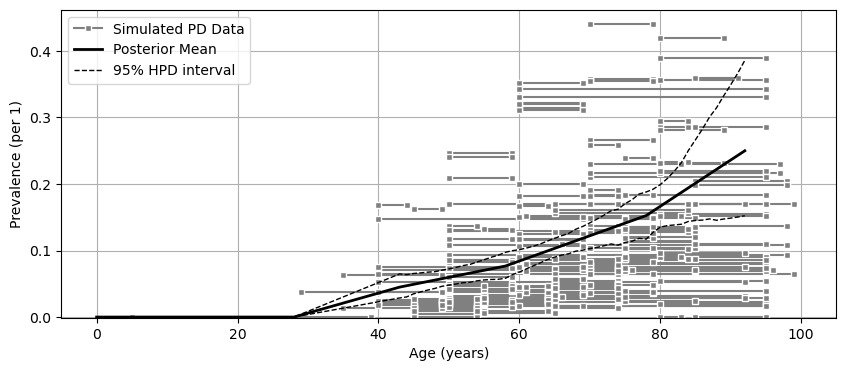

In [190]:
plt.figure(figsize=(10, 4))
data_bars(
    df=data,
    color='grey',
    label='Simulated PD Data'
)

hpd = pm.stats.hdi(pred, hdi_prob=0.95)
ages = np.arange(pred.shape[1])

plt.plot(
    ages,
    pred.mean(axis=0),
    'k-', linewidth=2,
    label='Posterior Mean'
)
plt.plot(
    ages,
    hpd[:, 0],
    'k--', linewidth=1,
    label='95% HPD interval'
)
plt.plot(
    ages,
    hpd[:, 1],
    'k--', linewidth=1
)

plt.xlabel('Age (years)')
plt.ylabel('Prevalence (per 1)')
plt.grid()
plt.legend(loc='upper left')
plt.axis(ymin=-0.001, xmin=-5, xmax=105)

In [76]:
inspect_model(pm_model, 'const_alpha_sigma_p', show_shared_data=False)

❌ Variable 'const_alpha_sigma_p' not found in model.named_vars.


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Step 6: 95% HPD(Highest Posterior Density) 계산 및 시각화
# ─────────────────────────────────────────────────────────────────────────────
hpd = pm.stats.hdi(pred, hdi_prob=0.95)
ages = np.arange(pred.shape[1])

plt.plot(
    ages,
    pred.mean(axis=0),
    'k-', linewidth=2,
    label='Posterior Mean'
)
plt.plot(
    ages,
    hpd[:, 0],
    'k--', linewidth=1,
    label='95% HPD interval'
)
plt.plot(
    ages,
    hpd[:, 1],
    'k--', linewidth=1
)

plt.xlabel('Age (years)')
plt.ylabel('Prevalence (per 1)')
plt.grid()
plt.legend(loc='upper left')
plt.axis(ymin=-0.001, xmin=-5, xmax=105)

In [106]:
# TODO 1: predict_for
# TODO 2: plot

In [ ]:
import model.predict as predict
print(predict.__file__)

plt.figure(figsize=(10, 4))
data_bars(
    df=data,
    color='grey',
    label='Simulated PD Data'
)

pred = predict.predict_for(
    model=model_old,
    parameters=model_old.parameters['p'],
    root_area='Global',
    root_sex='Both',
    root_year=2009,
    area='Global',
    sex='Female',
    year=2005,
    population_weighted=1.0,
    vars=model_old.vars['p'],
    lower=0.0,
    upper=1.0
)

print('----------------------------------------------------------------')
# print(pred.shape)
# print(pred.mean(axis=0).shape)
# print(pred.mean(axis=0))
print('----------------------------------------------------------------')

hpd = pm.stats.hdi(pred, hdi_prob=0.95)
ages = np.arange(pred.shape[1])

plt.plot(
    ages,
    pred.mean(axis=0),
    'k-', linewidth=2,
    label='Posterior Mean'
)
plt.plot(
    ages,
    hpd[:, 0],
    'k--', linewidth=1,
    label='95% HPD interval'
)
plt.plot(
    ages,
    hpd[:, 1],
    'k--', linewidth=1
)

plt.xlabel('Age (years)')
plt.ylabel('Prevalence (per 1)')
plt.grid()
plt.legend(loc='upper left')
plt.axis(ymin=-0.001, xmin=-5, xmax=105)

In [73]:
# Level 3: country
countries = (
    hier[hier["Level"] == 3]
    .rename(columns={
        "Location ID": "loc3_id",
        "Location Name": "country",
        "Parent ID": "parent2_id"
    })
    [["loc3_id", "country", "parent2_id"]]
)

# Level 2: region
regions = (
    hier[hier["Level"] == 2]
    .rename(columns={
        "Location ID": "loc2_id",
        "Location Name": "region",
        "Parent ID": "parent1_id"
    })
    [["loc2_id", "region", "parent1_id"]]
)

# Level 1: super-region
superregs = (
    hier[hier["Level"] == 1]
    .rename(columns={
        "Location ID": "loc1_id",
        "Location Name": "super_region"
    })
    [["loc1_id", "super_region"]]
)


NameError: name 'hier' is not defined

In [4]:
# 4.1 country 정보 붙이기
df = df.merge(countries, on="country", how="left")

# 4.2 region 정보 붙이기
df = df.merge(
    regions,
    left_on="parent2_id",
    right_on="loc2_id",
    how="left"
)

# 4.3 super-region 정보 붙이기
df = df.merge(
    superregs,
    left_on="parent1_id",
    right_on="loc1_id",
    how="left"
)

# 확인
df[["country","region","super_region"]].drop_duplicates().head()

,country,region,super_region
0,Sweden,Western Europe,High-income
1,United States of America,High-income North America,High-income
3,Israel,Western Europe,High-income
5,Switzerland,Western Europe,High-income
7,Canada,High-income North America,High-income


In [5]:

# 2) 매핑 딕셔너리
age_map  = {"Children":0, "Adult":1, "Both":2}
meth_map = {
    "Interview based":0,
    "Non-interview":1
}
prev_map = {
    "point prevalence":     0,
    "12-month prevalence":  1,
    "life-time prevalence": 2
}

# 3) long 포맷으로 전환
df_long = df.melt(
    id_vars=[
        "study",             
        "country",
        "region",
        "super_region",
        "Methods of questionnaire",
        "Age range",
        "study population"
    ],
    value_vars=[
        "point prevalence",
        "12-month prevalence",
        "life-time prevalence"
    ],
    var_name="prevalence_type",
    value_name="prevalence_value"
).dropna(subset=["prevalence_value"])

# 4) 코드 매핑
df_long["age_code"]  = df_long["Age range"].map(age_map)
df_long["meth_code"] = df_long["Methods of questionnaire"].map(meth_map)
df_long["prev_code"] = df_long["prevalence_type"].map(prev_map)

# 5) 최종 확인
result = df_long[[
    "study", "country", "region", "super_region",
    "age_code", "meth_code",
    "prev_code", "prevalence_value"
]]
print(result.head())

                     study                   country  \
0   Nilsson LV et al, 1984                    Sweden   
1     Kramer M et al, 1985  United States of America   
2    Flament M et al, 1990  United States of America   
3     Zohar AH et al, 1992                    Israel   
4  Reinherz HZ et al, 1993  United States of America   

                      region super_region  age_code  meth_code  prev_code  \
0             Western Europe  High-income         1          0          0   
1  High-income North America  High-income         1          0          0   
2  High-income North America  High-income         1          0          0   
3             Western Europe  High-income         0          0          0   
4  High-income North America  High-income         0          0          0   

   prevalence_value  
0              98.0  
1              22.0  
2              55.0  
3              36.0  
4              21.0  


In [6]:
# 6) 비율(p_hat) 및 로그 변환
#    prevalence_value: point/12-month/life-time 케이스 수
#    study population: 전체 표본 수

# 6.1 p_hat 계산
df_long["p_hat"] = df_long["prevalence_value"] / df_long["study population"]

# 6.2 로그 변환 (필요 시 0 회피를 위해 clamp)
eps = 1e-6
df_long["p_hat"] = df_long["p_hat"].clip(eps, 1 - eps)
df_long["log_p_hat"] = np.log(df_long["p_hat"])

In [ ]:
# 1) df_long 이용: prevalence_type 당 개수 세기
prev_count = df_long.groupby("study")["prevalence_type"] \
                    .transform("nunique")

# 2) 2개 이상이면 1, 아니면 0
df_long["multi_mask"] = (prev_count >= 2).astype(int)

# 3) 확인
df_long[["study","prevalence_type","multi_mask"]].drop_duplicates().head()

,study,prevalence_type,multi_mask
0,"Nilsson LV et al, 1984",point prevalence,0
1,"Kramer M et al, 1985",point prevalence,0
2,"Flament M et al, 1990",point prevalence,1
3,"Zohar AH et al, 1992",point prevalence,0
4,"Reinherz HZ et al, 1993",point prevalence,0


In [8]:
import pandas as pd

# 1) hierarchy 에서 좌표(리스트) 직접 추출
# level 1 → super_region (7개)
super_list = (
    hier[hier["Level"] == 1]
    ["Location Name"]
    .tolist()
)

# level 2 → region (21개)
region_list = (
    hier[hier["Level"] == 2]
    ["Location Name"]
    .tolist()
)

# level 3 → country (180+개)
country_list = (
    hier[hier["Level"] == 3]
    ["Location Name"]
    .tolist()
)

# 2) coords 정의 (unchanged)
coords = {
    "country":      country_list,
    "region":       region_list,
    "super_region": super_list,
    "age":          ["Children", "Adult", "Both"],
    "meth":         ["Interview based", "Non-interview"],
    "prev":         ["point prevalence", "12-month prevalence", "life-time prevalence"],
    "study":        df_long["study"].unique().tolist()
}

# 3) questionnaire method 컬럼명 변경 반영
#    이미 엑셀에서 "Methods of questionnaire" 아래 값을 "Interview based" / "Non-interview"로 바꿔 두셨다면
meth_map = {
    "Interview based":    0,
    "Non-interview":      1
}
df_long["meth_code"] = df_long["Methods of questionnaire"].map(meth_map)

# 4) index 배열 생성
country_idx = pd.Categorical(
    df_long["country"],
    categories=coords["country"]
).codes

region_idx = pd.Categorical(
    df_long["region"],
    categories=coords["region"]
).codes

super_idx = pd.Categorical(
    df_long["super_region"],
    categories=coords["super_region"]
).codes

age_idx   = df_long["age_code"].to_numpy()
meth_idx  = df_long["meth_code"].to_numpy()         
prev_idx  = df_long["prev_code"].to_numpy()

study_idx = pd.Categorical(
    df_long["study"],
    categories=coords["study"]
).codes

# 5) mask / 관측치 벡터 (unchanged)
multi_mask = df_long["multi_mask"].to_numpy()
y_obs      = df_long["log_p_hat"].to_numpy()


In [ ]:


with pm.Model(coords=coords) as model:

    # ─── Fixed effects ───
    β0    = pm.Normal("β0",    mu=0, sigma=10)
    β_age = pm.Normal("β_age", mu=0, sigma=5, dims="age")
    β_meth= pm.Normal("β_meth",mu=0, sigma=5, dims="meth")
    β_prev= pm.Normal("β_prev",mu=0, sigma=5, dims="prev")

    # ─── Non-centered random intercepts ───
    σ_sr = pm.HalfNormal("σ_sr", sigma=5)
    η_sr = pm.Normal("η_sr", mu=0, sigma=1, dims="super_region")
    u_sr = pm.Deterministic("u_sr", η_sr * σ_sr)

    σ_r  = pm.HalfNormal("σ_r", sigma=5)
    η_r  = pm.Normal("η_r",  mu=0, sigma=1, dims="region")
    u_r  = pm.Deterministic("u_r", η_r * σ_r)

    σ_c  = pm.HalfNormal("σ_c", sigma=5)
    η_c  = pm.Normal("η_c",  mu=0, sigma=1, dims="country")
    u_c  = pm.Deterministic("u_c", η_c * σ_c)

    # ─── Study-level random slope (non-centered) ───
    σ_ps= pm.HalfNormal("σ_prev_study", sigma=5)
    η_ps= pm.Normal("η_prev_study", mu=0, sigma=1, dims=("study","prev"))
    u_ps= pm.Deterministic("u_prev_study", η_ps * σ_ps)

    # ─── 선형 예측식 μ ───
    prev_effect = (β_prev[prev_idx] + u_ps[study_idx,prev_idx]) * multi_mask

    μ = (
        β0
        + β_age[age_idx]
        + β_meth[meth_idx]
        + prev_effect
        + u_sr[super_idx]
        + u_r[region_idx]
        + u_c[country_idx]
    )

    # ─── 관측모형 ───
    σ_y = pm.HalfNormal("σ_y", sigma=1)
    pm.Normal("y", mu=μ, sigma=σ_y, observed=y_obs)

    # ─── (옵션) ADVI 워밍업 — 빠르게 근사 posterior 생성 ───
    advi = pm.fit(method="advi", n=5000)

    # ─── NUTS 샘플링 ───
    idata = pm.sample(
        draws=1000, tune=500,
        chains=4, cores=4,
        target_accept=0.95,
        max_treedepth=15,
        progressbar="split"
    )

# ─── forest plot 으로 깔끔하게 시각화 ───
az.style.use("arviz-darkgrid")
az.plot_forest(
    idata,
    var_names=["β_age","β_meth","β_prev","σ_sr","σ_r","σ_c","σ_prev_study","σ_y"],
    combined=True,
    credible_interval=0.95,
    ridgeplot_overlap=0.5
)


Output()

Finished [100%]: Average Loss = 395.52
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β0, β_age, β_meth, β_prev, σ_sr, η_sr, σ_r, η_r, σ_c, η_c, σ_prev_study, η_prev_study, σ_y]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 7188 seconds.


TypeError: plot_forest() got an unexpected keyword argument 'credible_interval'

In [12]:
import arviz as az

# idata는 이미 pm.sample()의 결과
summary_df = az.summary(
    idata,
    var_names=[
        "β0", "β_age", "β_meth", "β_prev",
        "σ_sr", "σ_r", "σ_c", "σ_prev_study", "σ_y"
    ],
    round_to=3,         # 소수점 자리수
    hdi_prob=0.95       # 95% 신뢰구간
)
print(summary_df)


                               mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  \
β0                           -3.537  4.085   -11.136      4.469      0.111   
β_age[Children]              -0.263  2.759    -5.733      4.756      0.080   
β_age[Adult]                 -0.284  2.752    -5.538      4.946      0.080   
β_age[Both]                  -0.183  2.763    -5.575      4.984      0.080   
β_meth[Interview based]       0.241  3.283    -6.431      6.356      0.080   
β_meth[Non-interview]        -0.924  3.280    -7.457      5.359      0.080   
β_prev[point prevalence]     -1.014  0.388    -1.760     -0.244      0.006   
β_prev[12-month prevalence]  -0.401  0.291    -0.957      0.177      0.006   
β_prev[life-time prevalence] -0.121  0.290    -0.680      0.434      0.006   
σ_sr                          0.916  0.575     0.008      1.955      0.017   
σ_r                           0.291  0.242     0.000      0.755      0.008   
σ_c                           0.455  0.218     0.011      0.816 

In [13]:


# 1) posterior를 (chain, draw) → sample 차원 하나로 합치기
post = idata.posterior.stack(sample=("chain","draw"))

# 2) coords에 저장된 리스트 불러오기
country_list      = coords["country"]       # Level-3 국가 이름 리스트
super_list        = coords["super_region"]  # Level-1 슈퍼리전
region_list       = coords["region"]        # Level-2 리전
age_list          = coords["age"]           # ["Children","Adult","Both"]
meth_list         = coords["meth"]          # ["Interview based","Non-interview"]
prev_list         = coords["prev"]          # ["point prevalence","12-month prevalence","life-time prevalence"]

# 3) 관심 범주의 posterior 샘플 꺼내기
β0_samps         = post["β0"].values                             # (samples,)
β_age_Both       = post["β_age"].sel(age="Both").values          # (samples,)
β_meth_IB        = post["β_meth"].sel(meth="Interview based").values  # (samples,)
β_prev_life      = post["β_prev"].sel(prev="life-time prevalence").values  # (samples,)

u_sr_samps       = post["u_sr"].values      # (super_region, samples)
u_r_samps        = post["u_r"].values       # (region, samples)
u_c_samps        = post["u_c"].values       # (country, samples)

# 4) country → region, super_region 매핑 (levels 파일에서 미리 만들어 두었다면 그것 사용)
#    여기선 hier 데이터프레임에 있는 Level, Location Name, Parent ID 이용
mapping = hier[["Level","Location ID","Location Name","Parent ID"]]
# Level3
lvl3 = mapping[mapping["Level"]==3].rename(columns={
    "Location Name":"country","Location ID":"loc3","Parent ID":"parent2"
})
# Level2
lvl2 = mapping[mapping["Level"]==2].rename(columns={
    "Location Name":"region","Location ID":"loc2","Parent ID":"parent1"
})
# Level1
lvl1 = mapping[mapping["Level"]==1].rename(columns={
    "Location Name":"super_region","Location ID":"loc1"
})

# merge to get each country’s region & super_region names
df_map = (
    lvl3[["country","loc3","parent2"]]
    .merge(lvl2[["loc2","region","parent1"]], left_on="parent2", right_on="loc2", how="left")
    .merge(lvl1[["loc1","super_region"]], left_on="parent1", right_on="loc1", how="left")
    [["country","region","super_region"]]
)

# 5) Monte Carlo 샘플마다 μ 계산 → p = exp(μ)
results = []
n_samps = β0_samps.shape[0]
for idx, row in df_map.iterrows():
    country    = row["country"]
    region     = row["region"]
    super_reg  = row["super_region"]
    i_sr = super_list.index(super_reg)
    i_r  = region_list.index(region)
    i_c  = country_list.index(country)

    # μ 샘플 벡터
    mu = (
        β0_samps
        + β_age_Both
        + β_meth_IB
        + β_prev_life
        + u_sr_samps[i_sr, :]
        + u_r_samps[i_r, :]
        + u_c_samps[i_c, :]
    )
    # prevalence 비율로 변환
    p = np.exp(mu)

    # median & 95% HDI
    med = np.median(p)
    hdi_lo, hdi_hi = az.hdi(p, hdi_prob=0.95)

    results.append({
        "country":             country,
        "region":              region,
        "super_region":        super_reg,
        "median_life_prev":    med,
        "hdi_2.5%":            hdi_lo,
        "hdi_97.5%":           hdi_hi
    })

df_out = pd.DataFrame(results)

# 6) 엑셀로 저장
output_path = "C:/Users/정이든/Desktop/연구실/9. prevalence of OCD/3차 와꾸/life_time_prevalence.xlsx"
df_out.to_excel(output_path, index=False)
print(f"Saved to {output_path}")


Saved to C:/Users/정이든/Desktop/연구실/9. prevalence of OCD/3차 와꾸/life_time_prevalence.xlsx
